['rb0', 'hc0', 'ni0', 'zn0', 'cu0', 'j10', 'i10', 'jm0', 'MA0', 'pb0']


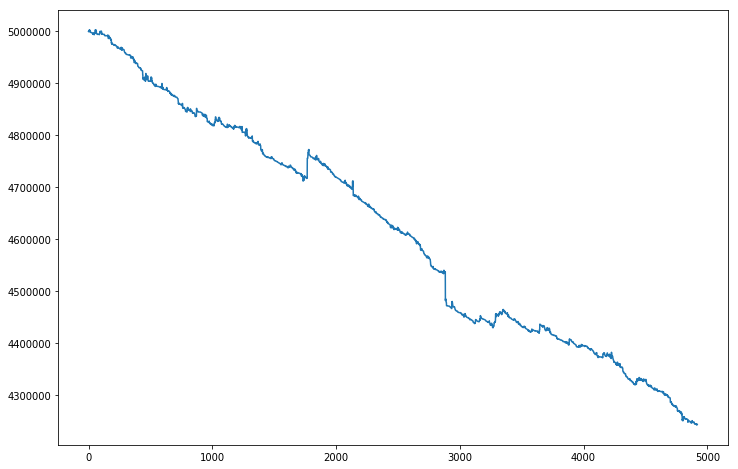

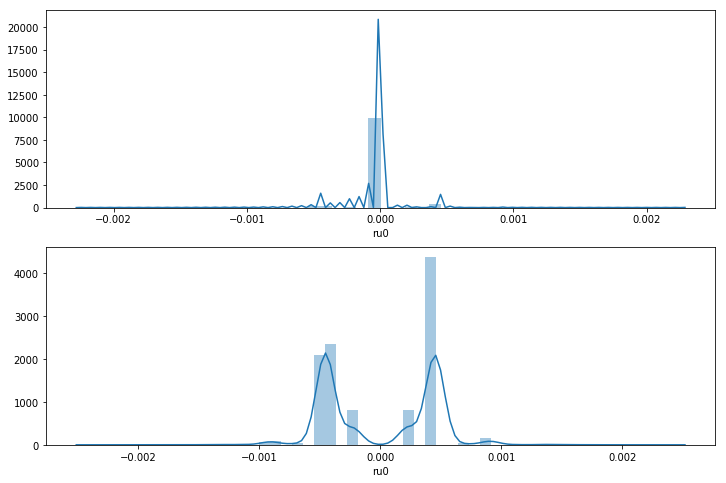

std of none-zero df is 0.000463
corr between train_predict and train_y
          pred      true
pred  1.000000  0.135109
true  0.135109  1.000000
corr between test_predict and test_y
          pred      true
pred  1.000000  0.085472
true  0.085472  1.000000


In [ ]:
#! /home/hui/anaconda2/bin/python
#coding:utf-8
import research
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import os
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle


target = 'ru0'
train_start, train_end, test_start, test_end = '20180326', ' 20180329', '20180330', '20180330'
period = '1s'
if period == '0s':
    lag = '500ms'
else:
    lag = period
resample = False
resample_period = '2s'

def easy_ensemble(data, clf, target=target,n_model='default', zero_no_zero_times = 2, cut_outlier=True):
    if n_model == 'default':
        count = 0  # 0记录的数量
        for val in data[target].values:
            if val == 0:
                count += 1
        l = data.shape[0]
        n_model = count / (l - count) / zero_no_zero_times  # 使得划分的模型数和0值、非0值比值是指定的比值，这样就能保证每个clf的数据里非0和0值差不多
    target_col = data[target].values
    zero_flag = [True if val == 0 else False for val in target_col]
    not_zero_flag = [True if val != 0 else False for val in target_col]
    zero_records = data[zero_flag]
    not_zero_records = data[not_zero_flag]
    if cut_outlier:  # 去掉非零值中的outliers
        mean = np.mean(not_zero_records.values)
        std = np.std(not_zero_records.values)
        flag=[]
        for val in not_zero_records[target].values:
            flag1, flag2 = False, False
            if val <= mean + 3*std:
                flag1 = True
            if val >= mean - 3*std:
                flag2 = True
            if flag1 and flag2:
                flag.append(True)
            else:
                flag.append(False)
        not_zero_records = not_zero_records[flag]
    zero_dic = df_split(zero_records, n=n_model)
    clf_dic, train_score = {}, {}
    for key in zero_dic.keys():
        this_df = pd.concat([not_zero_records, zero_dic[key]])
        this_df = shuffle(this_df)
        this_x, this_y = train.split_x_y(this_df)
        clf.fit(this_x, this_y)
        train_score[key] = clf.score(this_x, this_y)
        clf_dic[key] = clf
    return clf_dic, train_score

def df_split(data, n):
    '''split dataframe into n parts , mainly split zero-values dataframe and concat with none-zero dataframe to ensemble'''
    data = shuffle(data)
    l = data.shape[0]
    len_per_part = l/n
    dic = {}
    num=1
    start=0
    while num< n:
        end = start+len_per_part
        temp = data.iloc[start:end,:]
        dic[str(num)] = temp
        start=end
        num+=1
    dic[str(n)] = data.iloc[start:,:]
    return dic

def easy_ensemble_predict(x, clf_dic, score_dic):
    score_sum = sum(score_dic.values())
    weight = {}
    res = [0 for i in range(x.shape[0])]
    for key in score_dic.keys():
        weight[key] = score_dic[key]/ score_sum
        this_clf = clf_dic[key]
        this_pred = this_clf.predict(x)
        res += weight[key] * this_pred
    return res

def asset_plot(asset_record):
    max_list, min_list = [], []
    values = asset_record.values()
    for i in range(len(asset_record)):
        max_list.append(values[i][0])
        min_list.append(values[i][1])
    plt.plot(max_list, label='max')
    plt.plot(min_list, label='min')
    plt.legend()
    plt.show()

def get_best_thres(dic, max_weight = 1, min_weight = 1): # 从asset记录中获取最好的一条记录
    profit = map(lambda set_x : [int(set_x[0])-5000000,int(set_x[-1])-5000000], record.values())
    max_profit = -1000000
    best_thres = 0
    for i in range(len(profit)):
        this_profit = profit[i][0] + profit[i][1]
        if this_profit > max_profit:
            max_profit = this_profit
            best_thres = i
            print profit[i][0], profit[i][1]
    return dic.keys()[best_thres]

def get_best_thres_by_tr_test(train_dic, test_dic, train_weig, test_weig, max_weight = 1, min_weight = 1): # 从asset记录中获取最好的一条记录
    train_profit = map(lambda set_x : [int(set_x[0])-5000000,int(set_x[-1])-5000000], train_dic.values())
    test_profit = map(lambda set_x : [int(set_x[0])-5000000,int(set_x[-1])-5000000], test_dic.values())
    max_profit = -1000000
    best_thres = 0
    for i in range(len(train_profit)):
        this_profit = (train_profit[i][0] + train_profit[i][1])*train_weig+(test_profit[i][0] + test_profit[i][1])*test_weig
        if this_profit > max_profit:
            max_profit = this_profit
            best_thres = i
            print test_profit[i][0], test_profit[i][1]
    return train_dic.keys()[best_thres]

# def cut_outlier(data, target_col=target, thres=3):   # 去掉数值大于thres倍方差的
#     df = data.copy()
#     scaled = StandardScaler().fit_transform(df[target_col][:,np.newaxis])
#     flag = [True if abs(val) <= thres else False for val in scaled]
#     return data[flag]

rese = research.Research(target=target)
train = research.Train(target=target)

tickerlst = rese.get_symbols(period=0, lag=500, num=10) # get most related tickers from database
print tickerlst

train_daylst = rese.generate_daylst(train_start, train_end) # get train and test day list
test_daylst = rese.generate_daylst(test_start, test_end)

train_data = rese.load_data(tickerlst, daylst=train_daylst, lag=lag, period = period) # read un-lagged data from local and then lag it
test_data = rese.load_data(tickerlst, daylst=test_daylst, lag=lag, period = period)
none_zero_flag = [True if val != 0 else False for val in train_data[target].values]
none_zero = train_data[none_zero_flag]

plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
sns.distplot(train_data[target])

plt.subplot(2,1,2)
sns.distplot(none_zero[target])
plt.show()
none_zero_std = np.std(none_zero[target])
print 'std of none-zero df is %f' %none_zero_std  # 查看是不是有部分非零数据超出了3倍std

train_price = rese.load_price(train_daylst,lag)  # load un-lagged price data and then lag it
test_price = rese.load_price(test_daylst, lag)

if resample:
    train_data = train.sample(resample_period=resample_period, df=train_data, keep_target_no_zero=False)
    test_data = train.sample(resample_period = resample_period, df=test_data, keep_target_no_zero=False)

from sklearn.linear_model import Ridge, RidgeCV
clf = RidgeCV(alphas=np.arange(0.01,1,0.01),normalize=True)
clf_dic , score_dic = easy_ensemble(train_data, clf)

train_x, train_y= train.split_x_y(train_data)
train_predict = easy_ensemble_predict(train_x, clf_dic, score_dic)

contrast = pd.DataFrame({'pred':train_predict, 'true':train_y})
print 'corr between train_predict and train_y'
print contrast.corr()

test_x, test_y = train.split_x_y(test_data)
test_predict = easy_ensemble_predict(test_x, clf_dic, score_dic)
test_contrast = pd.DataFrame({'pred':test_predict, 'true':test_y})
print 'corr between test_predict and test_y'
print test_contrast.corr()


# start trade simulation
trade = research.Trade(target)
model_name = 'ridge_ensemble'
date = str(pd.datetime.now()).split(' ')[0]

# use ask_price and bid_price to trade

buy_start, buy_end, buy_gap = 1, 4, 0.1
sell_start, sell_end, sell_gap = -1 ,-4, -0.1
to_save_dir = '/home/hui/Documents/output/trade_asset/'+model_name+'/'+date+'/train/ask_bid/'
if not os.path.exists(to_save_dir):
    os.makedirs(to_save_dir)
record_ask_bid = {}
for buy_thres in np.arange(buy_start,buy_end, buy_gap):
    for sell_thres in np.arange(sell_start,sell_end, sell_gap):
        pair = str(buy_thres)+'_'+str(sell_thres)
        asset = trade.simu_trade1(train_price, train_predict, buy_threshold=buy_thres,sell_threshold=sell_thres
                                  , hold_per_trade=50)
        record_ask_bid[pair] = (max(asset), min(asset))
#         plt.figure(figsize= (12,8))
#         plt.plot(asset)
#         plt.title(str(buy_thres)+' : '+str(sell_thres))
#         plt.savefig(to_save_dir+pair+'.jpg')
#         plt.close()

record_test_ask_bid = {}
for buy_thres in np.arange(buy_start,buy_end, buy_gap):
    for sell_thres in np.arange(sell_start,sell_end, sell_gap):
        pair = str(buy_thres)+'_'+str(sell_thres)
        test_asset = trade.simu_trade1(test_price, test_predict, buy_threshold=buy_thres,sell_threshold=sell_thres
                                  , hold_per_trade=50)
        record_test_ask_bid[pair] = (max(asset), min(asset))
#         plt.figure(figsize= (12,8))
#         plt.plot(test_asset)
#         plt.title(str(buy_thres)+' : '+str(sell_thres))
#         plt.savefig(to_save_dir+pair+'.jpg')
#         plt.close()

thres = get_best_thres_by_tr_test(record_ask_bid, record_test_ask_bid, 0.4,0.6).split('_')
buy_thres, sell_thres = float(thres[0]), float(thres[1])
print 'best buy_thres at: %f, sell_thres at: %f' %(buy_thres, sell_thres)

def test_model(daylst, clf_dic=clf_dic, score_dic=score_dic, load_instance=rese, train_instance=train, trade_instance=trade,
    tickerlst=tickerlst, target=target, lag=lag, period=period, buy_thres=buy_thres, sell_thres=sell_thres):
    tmp_data = load_instance.load_data(tickerlst, daylst, lag, period)
    tmp_price = load_instance.load_price(daylst, lag)
    tmp_x, tmp_y = train_instance.split_x_y(tmp_data)
    tmp_predict = easy_ensemble_predict(tmp_x, clf_dic, score_dic)
    corr = np.corrcoef(tmp_predict, tmp_y)[0][-1]
    print 'corr value between predict value and true value is: %f' %corr
    tmp_asset = trade_instance.simu_trade1(tmp_price, tmp_predict,buy_thres, sell_thres,
        hold_per_trade=50)
    plt.figure(figsize= (10,6))
    plt.title('asset track of test data')
    plt.plot(tmp_asset)
    plt.show()


# # use mid_price only to trade
# to_save_dir = '/home/hui/Documents/output/trade_asset/'+model_name+'/'+date+'/train/mid/'
# if not os.path.exists(to_save_dir):
#     os.makedirs(to_save_dir)
# record_mid = {}
# for buy_thres in np.arange(buy_start,buy_end, buy_gap):
#     for sell_thres in np.arange(sell_start,sell_end, sell_gap):
#         pair = str(buy_thres)+'_'+str(sell_thres)
#         asset = trade.simu_trade2(train_price, train_predict, buy_threshold=buy_thres,sell_threshold=sell_thres
#                                   , hold_per_trade=50)
#         record_mid[pair] = (max(asset), min(asset))
#         plt.figure(figsize= (12,8))
#         plt.plot(asset)
#         plt.title(buy_thres+' : '+sell_thres)
#         plt.savefig(to_save_dir+pair+'.jpg')
#         plt.close()

# thres_ask_bid = get_best_thres(record_ask_bid).split('_')
# buy_thres_ask_bid, sell_thres_ask_bid = float(thres_ask_bid[0]), float(thres_ask_bid[1])

# thres_mid = get_best_thres(record_mid).split('_')
# buy_thres_mid, sell_thres_mid = float(thres_mid[0]), float(thres_mid[1])

asset = trade.simu_trade1(train_price, train_predict, buy_threshold=buy_thres,sell_threshold=sell_thres
                                  , hold_per_trade=50)
plt.figure(figsize= (10,6))
plt.title('asset track of train data, trade at ask price and bid price with threshold at:'+str(buy_thres)+' : '+str(sell_thres))
plt.plot(asset)
plt.savefig(to_save_dir+'/model_results/train_ask_bid_best.jpg')
# plt.show()
plt.close()

test_asset = trade.simu_trade1(test_price, train_predict, buy_threshold=buy_thres,sell_threshold=sell_thres
                                  , hold_per_trade=50)
plt.figure(figsize= (10,6))
plt.title('asset track of test data, trade at ask price and bid price with threshold at:'+str(buy_thres)+' : '+str(sell_thres))
plt.plot(test_asset)
plt.savefig(to_save_dir+'/model_results/test_ask_bid_best.jpg')
# plt.show()
plt.close()

# asset_mid = trade.simu_trade1(train_price, train_predict, buy_threshold=buy_thres_mid,sell_threshold=sell_thres_mid
#                                   , hold_per_trade=50)
# plt.figure(figsize= (10,6))
# plt.title('asset track of train data, trade at mid_price')
# plt.plot(asset)
# plt.savefig(to_save_dir+'train_mid_best.jpg')
# # plt.show()
# plt.close()

